In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from numpy.linalg import norm, inv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import hdbscan
import cv2
import os
from operator import itemgetter
from visualization_dimensionality_red_functions import *
from clustering_functions import *

# Load files

Load features

In [2]:
vgg_features = scipy.io.loadmat('girosmallveryslow2_vggfeatures.mat')['features']
clip = scipy.io.loadmat('girosmallveryslow2_clipfeatures.mat')["features"]


features = np.concatenate((vgg_features, clip), axis=0)

Load outliers

In [3]:
outliers = np.load('outliers.npy')

Load video

In [4]:
video = cv2.VideoCapture('girosmallveryslow2.mp4')

Load images

In [5]:
folder = 'images_giroslow'
images_path = sorted(os.listdir(folder), key=lambda x: os.path.getmtime(os.path.join(folder, x)))

# Outlier removal

In [6]:
features_w_outliers = np.delete(features, outliers, axis=1)
images_path_w_outliers = np.delete(images_path, outliers, axis=0)

# Center data 

In [7]:
features_cnt_w_outliers, scaler = data_centering(features_w_outliers)

# Rank and dimensionality reduction

Get rank

In [ ]:
svd = data_visualization(features_cnt_w_outliers, method='svd', n_components=features_cnt_w_outliers.shape[0])

# Calculate the rank of the features
cum_var = np.cumsum(svd.explained_variance_ratio_)
rank = np.where(cum_var > 0.90)[0][0] + 1
print('Rank:', rank)

Get reduced data

In [36]:
embeddings = dimensionality_reduction(features_w_outliers, method='umap', n_components=10, n_neighbors=15) # use UMAP to reduce dimensionality
# embeddings = dimensionality_reduction(features_w_outliers, method='tsne', n_components=10, n_neighbors=15) # use tnse to reduce dimensionality

Center reduced data

In [37]:
embeddings_centered = data_centering(embeddings)[0]

# Similarity matrix

Get similarity matrix

In [38]:
similarity_type = 4 # 1 for cosine and unreduced data, 2 for euclidean and unreduced data, 3 for cosine and reduced data, 4 for euclidean and reduced data

if similarity_type == 1:
    similarity_matrix = get_similarity_matrix(features_w_outliers, similarity='cosine')
elif similarity_type == 2:
    similarity_matrix = get_similarity_matrix(features_w_outliers, similarity='euclidean')
elif similarity_type == 3:
    similarity_matrix = get_similarity_matrix(embeddings, similarity='cosine')
elif similarity_type == 4:
    similarity_matrix = get_similarity_matrix(embeddings, similarity='euclidean')


Similarity matrix histogram

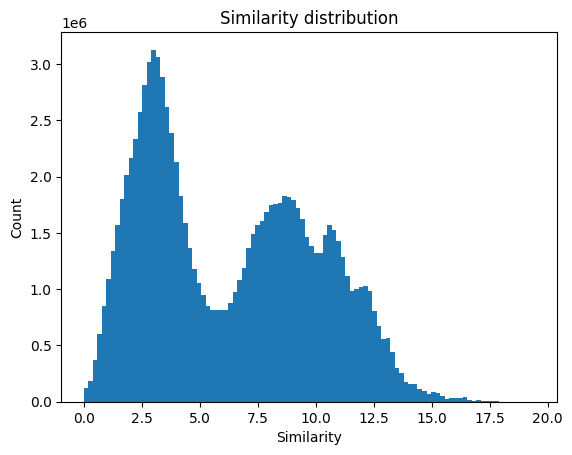

In [39]:
similarity_matrix_hist(similarity_matrix)

Get epsilon for DBSCAN

In [40]:
eps = float(np.quantile(similarity_matrix, 0.002))
print('Eps:', eps)

Eps: 0.29617589712142944


# DBSCAN Clustering

In [41]:
dbscan_clusterer = clusterer_function(method='DBSCAN', similarity_matrix=similarity_matrix, precomputed=True, min_samples=3, eps=eps)

Clusters sizes histogram

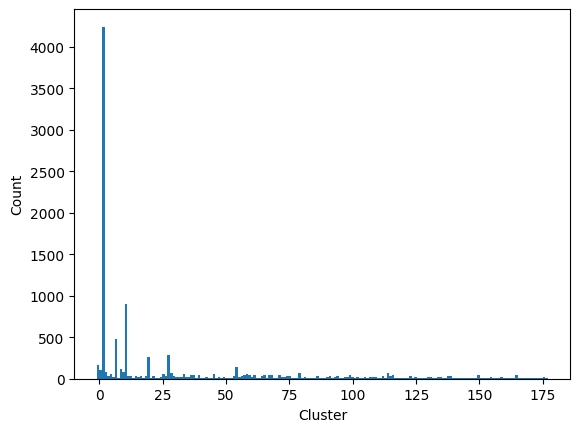

Number of clusters: 179
Highest number of elements in a clusters: 4240
Smallest number of elements in a clusters: 3


In [42]:
cluster_size_hist(dbscan_clusterer)

Unlabeled frames 

In [34]:
unlabled = np.where(dbscan_clusterer.labels_ == -1)[0]
print('Number of unlabled frames:', len(unlabled))

Number of unlabled frames: 3305


Unlabeled frames visualization

In [ ]:
visualization_w_images( cluster=unlabled, folder= folder, images_path=images_path_w_outliers)

Visualization of some random cluster

In [ ]:
visualization_w_images(cluster = np.where(dbscan_clusterer.labels_ == np.random.choice(dbscan_clusterer.labels_))[0], folder= folder, images_path=images_path_w_outliers)

The problem with dbscan is that, eventhough it gets most of the clusters correct, it breaks the data into to many clusters, so the necessity to merge them arises. The following code is a way to merge clusters based on the NSI values.

Put clusters in a dictionary

In [62]:
dbscan_cluster_dict = {}
for i in np.unique(dbscan_clusterer.labels_):
    if i != -1:
        dbscan_cluster_dict[i] = np.where(dbscan_clusterer.labels_ == i)[0]

Get bases for clusters and Compute NSI matrix

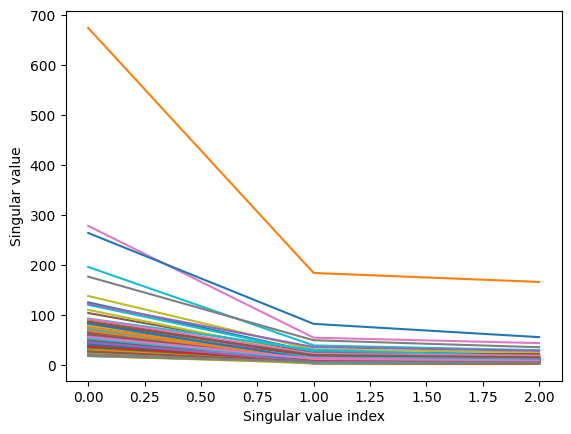

<AxesSubplot: ylabel='Count'>

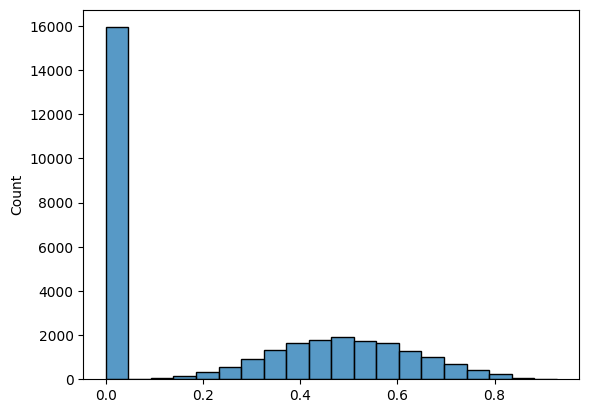

In [63]:
bases, sv = get_bases(dbscan_cluster_dict, features_w_outliers)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(dbscan_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)


Visualize sparse NSI matrix

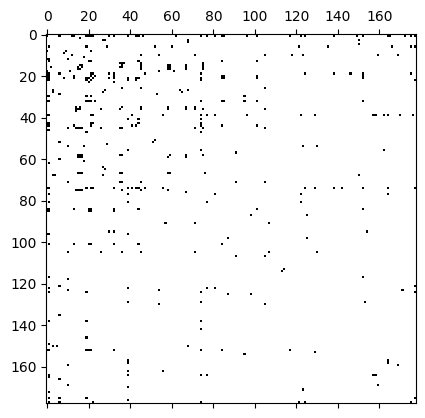

In [64]:
threshold = 0.8
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [65]:
dbscan_cluster_dict, NSI_matrix = final_cluster_merger(dbscan_cluster_dict, features_w_outliers, NSI_matrix, threshold)

Number of clusters:  171
Number of elements in biggest cluster:  4444


Number of clusters:  165
Number of elements in biggest cluster:  4791
Number of clusters:  159
Number of elements in biggest cluster:  4833
Number of clusters:  154
Number of elements in biggest cluster:  4839
Number of clusters:  148
Number of elements in biggest cluster:  4839
Number of clusters:  144
Number of elements in biggest cluster:  4868
Number of clusters:  138
Number of elements in biggest cluster:  4911
Number of clusters:  132
Number of elements in biggest cluster:  4914
Number of clusters:  128
Number of elements in biggest cluster:  4924
Number of clusters:  123
Number of elements in biggest cluster:  5443
Number of clusters:  120
Number of elements in biggest cluster:  5526
Number of clusters:  116
Number of elements in biggest cluster:  5544
Number of clusters:  112
Number of elements in biggest cluster:  5552
Number of clusters:  109
Number of elements in biggest cluster:  5598
Number of clusters:  106
Number of elements in biggest cluster:  5604
Number of clusters: 

Visualize random cluster

In [73]:
visualization_w_images(cluster = dbscan_cluster_dict[np.random.choice(list(dbscan_cluster_dict.keys()))], folder= folder, images_path=images_path_w_outliers)

Even with the merging by the NSI values there are still to many clusters, this happens because the initial clusters are to small, so they easily seem dissimilar.

# Clustering by cosine similarity

Cosine similarity plot between 1000 consecutive frames

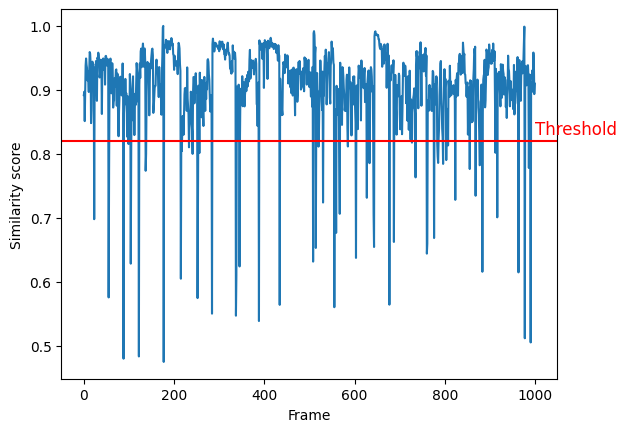

In [8]:
cluster_cos_dict, outliers_2 = clustering_by_cos_sim(features_w_outliers.T)
plt.show()

Visualize random cluster and second set of outliers

In [9]:
visualization_w_images(cluster = outliers_2, folder= folder, images_path=images_path_w_outliers)
visualization_w_images(cluster = cluster_cos_dict[np.random.choice(list(cluster_cos_dict.keys()))], folder= folder, images_path=images_path_w_outliers)

With the cosine similarity between consecutive frames we manage to catch the outliers that were not caught by first method used. 

Get bases for clusters and Compute NSI matrix

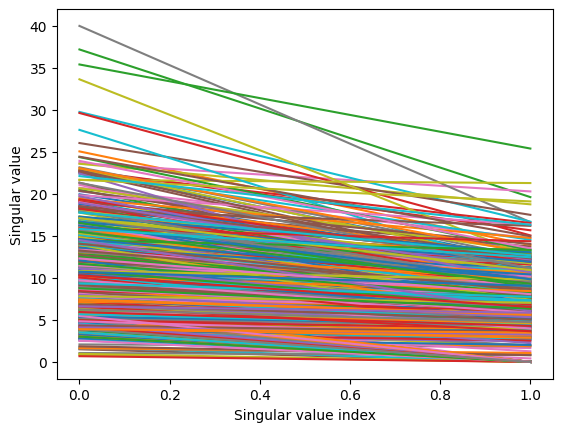

Text(0.5, 0, 'NSI')

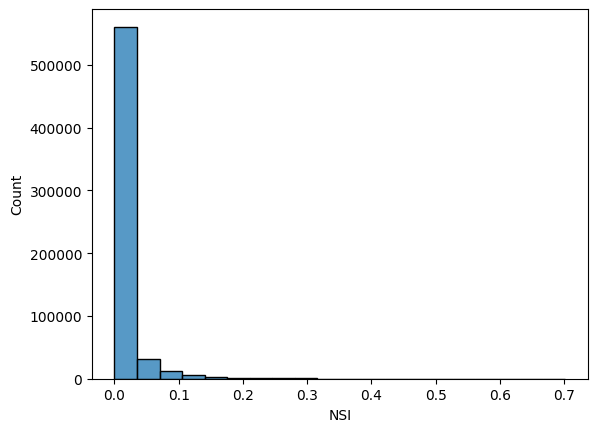

In [10]:
bases, sv = get_bases(cluster_cos_dict, features_w_outliers)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(cluster_cos_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)
plt.xlabel('NSI')

Visualize sparse NSI matrix

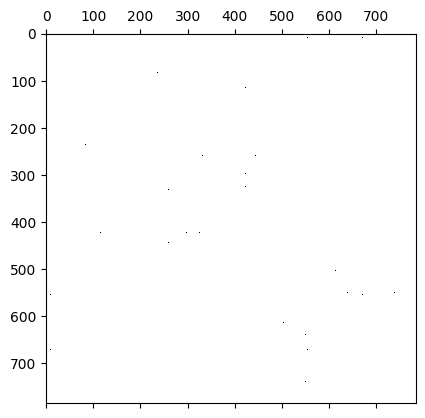

In [12]:
threshold = 0.5
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [ ]:
cluster_cos_dict, NSI_matrix = final_cluster_merger(cluster_cos_dict, features_w_outliers, NSI_matrix, threshold) 

Visualize random cluster

In [ ]:
clusters = np.random.choice(list(cluster_cos_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[cluster_cos_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

# KMeans clustering

In [13]:
KMeans_clusterer = clusterer_function(method='KMeans',data=features_cnt_w_outliers, n_clusters=10)

Clusters sizes histogram

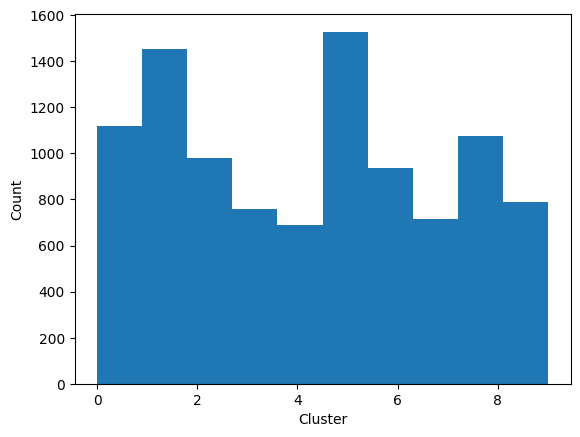

Number of clusters: 10
Highest number of elements in a clusters: 1528
Smallest number of elements in a clusters: 0


In [14]:
cluster_size_hist(KMeans_clusterer)

Create clusters dictionary

In [15]:
KMeans_cluster_dict = {}
for i in np.unique(KMeans_clusterer.labels_):
        KMeans_cluster_dict[i] = np.where(KMeans_clusterer.labels_ == i)[0]

Visualization of some random cluster

In [18]:
visualization_w_images(cluster = KMeans_cluster_dict[np.random.choice(list(KMeans_cluster_dict.keys()))], folder= folder, images_path=images_path_w_outliers)

Get bases for clusters and Compute NSI matrix

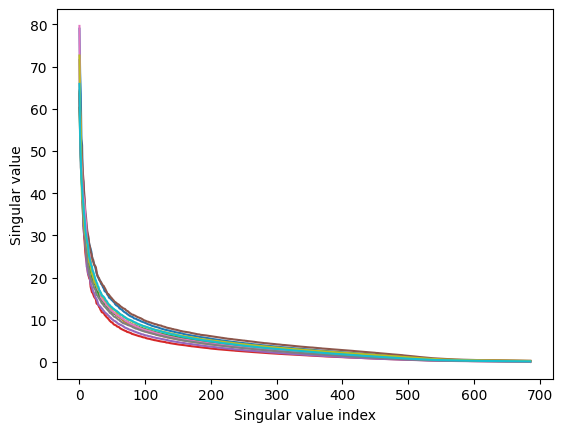

<AxesSubplot: ylabel='Count'>

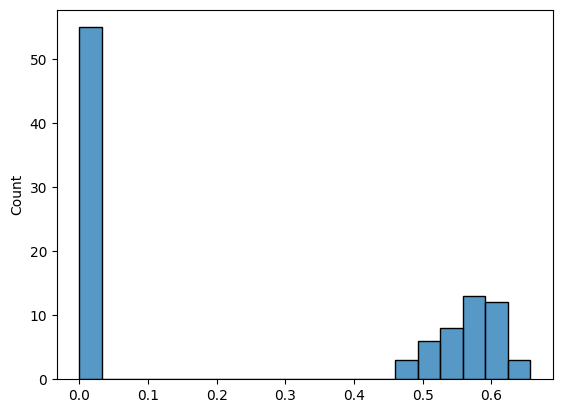

In [20]:
bases, sv = get_bases(KMeans_cluster_dict, features_cnt_w_outliers)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(KMeans_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)

Visualize sparse NSI matrix

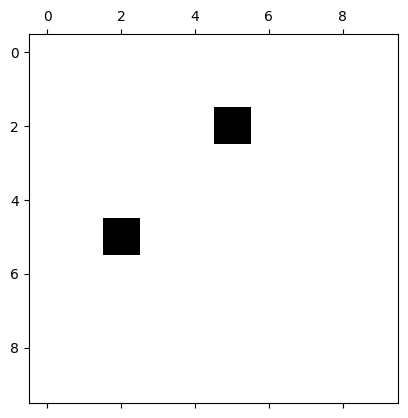

In [24]:
threshold = 0.65
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [25]:
KMeans_cluster_dict, NSI_matrix = final_cluster_merger(KMeans_cluster_dict, features_cnt_w_outliers, NSI_matrix, threshold)

Number of clusters:  9
Number of elements in biggest cluster:  2508
Number of clusters:  8
Number of elements in biggest cluster:  3297
Number of clusters:  6
Number of elements in biggest cluster:  5130


Visualize random cluster

In [27]:
clusters = np.random.choice(list(KMeans_cluster_dict.keys()), 6, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = KMeans_cluster_dict[cluster], folder= folder, images_path=images_path) # press q to exit to next cluster

By only using the features Kmeans clustering fails to cluster the frames in a meaningful way, it mixes various types of shots in the same cluster.